### **Importing Required Libraries**

In [69]:
import cv2
from matplotlib import pyplot as plt
from keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG19
import os
from PIL import Image
import numpy as np
import pickle
from keras.regularizers import l2

### **Loading Train Image and Test Image Data**

In [70]:
# Using the ImageDataGenerator technique to load the data

# Creating the train and test ImageDataGenerator instances
train_image_data_generator = ImageDataGenerator(
    rescale = 1./255
)

test_image_data_generator = ImageDataGenerator(
    rescale = 1./255
)

# Specifying the train directory and test directory inside a variable to use in different functions
train_directory = r'C:\Users\njain\OneDrive - Cal State Fullerton\SPRING 2024\CPSC 597 Project\Project\APMBSS\data\raw\face_detection\train'
test_directory = r'C:\Users\njain\OneDrive - Cal State Fullerton\SPRING 2024\CPSC 597 Project\Project\APMBSS\data\raw\face_detection\test'

# Loading the train data using flow_from_directory() method using `train_image_data_generator`
training_data = train_image_data_generator.flow_from_directory(
    directory = train_directory,
    target_size = (48, 48),
    batch_size = 32,
    color_mode = 'grayscale',
    class_mode = 'categorical'
)

# Loading the test data using flow_from_directory() method using `test_image_data_generator`
testing_data = test_image_data_generator.flow_from_directory(
    directory = test_directory,
    target_size = (48, 48),
    batch_size = 32,
    color_mode = 'grayscale',
    class_mode = 'categorical'
)

Found 23793 images belonging to 4 classes.
Found 5174 images belonging to 4 classes.


### **Visualising the Images**

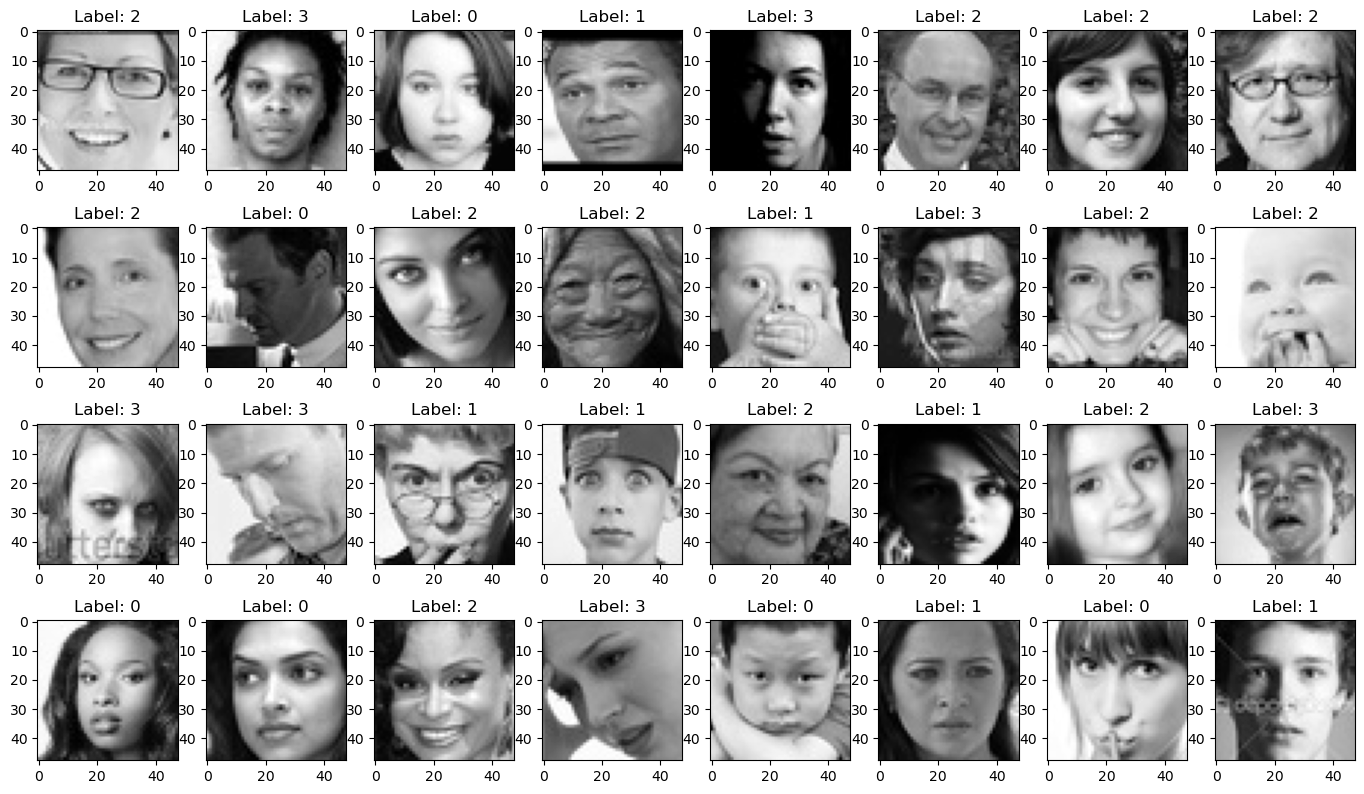

'\nBelow can be concluded from below:\nLabel 0: Calm\nLabel 1: Energetic\nLabel 2: Happy\nLabel 3: Sad\n'

In [71]:
# Getting a batch of images using next() function
sample_images, labels = next(training_data)

# Number of images to display
num_images = len(sample_images)

# Extract folder names from the generator's filenames
folder_names = [os.path.dirname(file) for file in training_data.filenames[:num_images]]

# Plotting the images using matplotlib
plt.figure(figsize =(17, 20))
for i in range(0, num_images):
    plt.subplot(8, 8, i + 1)
    plt.imshow(sample_images[i], cmap='gray')
    plt.title(f"Label: {labels[i].argmax()}")  # Display the one-hot encoded label

plt.show()

'''
Below can be concluded from below:
Label 0: Calm
Label 1: Energetic
Label 2: Happy
Label 3: Sad
'''

### **Plotting the Bar Graph Representing the Number of Items Inside the Categories Using Matplotlib**

#### **Train Data Plotting**

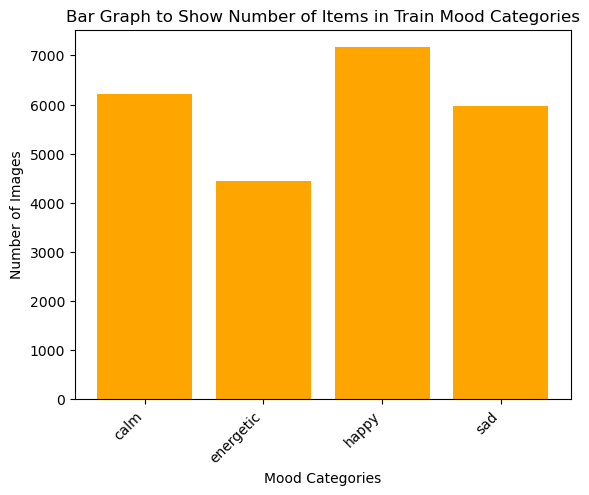

In [72]:
# Already defined the train directory path as train_directory
train_folders = [ folder for folder in os.listdir(train_directory) if os.path.isdir(os.path.join(train_directory, folder))]

folder_names_train = []
item_counts_train = []

for folder in train_folders:
    folder_path = os.path.join(train_directory, folder)
    num_items = len(os.listdir(folder_path))
    folder_names_train.append(folder)
    item_counts_train.append(num_items)

# Create a bar graph
plt.bar(folder_names_train, item_counts_train, color='orange')
plt.xlabel('Mood Categories')
plt.ylabel('Number of Images')
plt.title('Bar Graph to Show Number of Items in Train Mood Categories')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.show()

#### **Train Data Plotting**

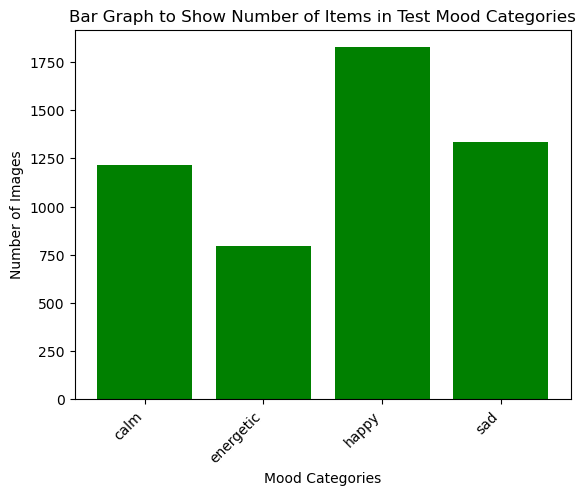

In [73]:
# Already defined the test directory path as test_directory path
test_folders = [ folder for folder in os.listdir(test_directory) if os.path.isdir(os.path.join(test_directory, folder))]

folder_names_test = []
item_counts_test = []

for folder in test_folders:
    folder_path = os.path.join(test_directory, folder)
    num_items = len(os.listdir(folder_path))
    folder_names_test.append(folder)
    item_counts_test.append(num_items)

# Create a bar graph
plt.bar(folder_names_test, item_counts_test, color='green')
plt.xlabel('Mood Categories')
plt.ylabel('Number of Images')
plt.title('Bar Graph to Show Number of Items in Test Mood Categories')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.show()

### **Preprocessing The Data**

### **Create a CNN Model For Image Classification**

In [63]:
# mood_detection_model Architecture
mood_detection_model = Sequential()
mood_detection_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
mood_detection_model.add(MaxPooling2D((2, 2)))
mood_detection_model.add(Conv2D(64, (3, 3), activation='relu'))
mood_detection_model.add(MaxPooling2D((2, 2)))
mood_detection_model.add(Flatten())
mood_detection_model.add(Dense(128, activation='relu'))
mood_detection_model.add(Dropout(0.5))
mood_detection_model.add(Dense(4, activation='softmax'))

In [29]:
# # Initializing the Sequential model of tensorflow to create a layered structure of CNN model
# mood_detection_model = Sequential()

# ## Creating CNN layers
# # Layer 1 - Input Layer:
# mood_detection_model.add(Conv2D(
#     32,
#     kernel_size = (3, 3),
#     activation = 'relu',
#     input_shape = (48, 48, 1),
#     padding = 'same',
#     kernel_regularizer=l2(0.01)
# ))
# # Adding a MaxPooling2D layer to reduce the spetial dimentions of the feature maps to retain important features
# mood_detection_model.add(MaxPooling2D(pool_size = (2, 2)))
# # Adding a DROPOUT layer to reduce the chances of overfitting
# mood_detection_model.add(Dropout(0.25))

# # Layer 2:
# mood_detection_model.add(Conv2D(
#     256,
#     kernel_size = (3, 3),
#     activation = 'relu'
# ))
# # Adding a MaxPooling2D layer to reduce the spetial dimentions of the feature maps to retain important features
# mood_detection_model.add(MaxPooling2D(pool_size = (2, 2)))
# mood_detection_model.add(Dropout(0.25))

# # Layer 3:
# mood_detection_model.add(Conv2D(
#     256,
#     kernel_size = (3, 3),
#     activation = 'relu'
# ))
# # Adding a MaxPooling2D layer to reduce the spetial dimentions of the feature maps to retain important features
# mood_detection_model.add(MaxPooling2D(pool_size = (2, 2)))
# # Adding a DROPOUT layer to reduce the chances of overfitting
# mood_detection_model.add(Dropout(0.25))

# # Flatten Layer - For flattenning the output from the previous layer into a 1D vector
# mood_detection_model.add(Flatten())

# # Adding a Dense layer
# mood_detection_model.add(Dense(
#     1024,
#     activation = 'relu'
# ))
# # Adding a DROPOUT layer to reduce the chances of overfitting
# mood_detection_model.add(Dropout(0.5))
# mood_detection_model.add(Dense(
#     4,
#     activation = 'softmax'
# ))

### **Compiling the CNN Classifier Model**

In [64]:
# Compiling the mood_detection_model
mood_detection_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

mood_detection_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_35 (MaxPooli  (None, 23, 23, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_36 (Conv2D)          (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_36 (MaxPooli  (None, 10, 10, 64)        0         
 ng2D)                                                           
                                                                 
 flatten_15 (Flatten)        (None, 6400)              0         
                                                                 
 dense_31 (Dense)            (None, 128)             

Trainable params: 838660 (3.20 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [30]:
# # Setting the initial learning rate
# initial_learning_rate = 0.001

# # Setting the learning rate scheduler as Exponential decay, to adaptively adjust the learning rate while training the data
# learning_rate_scheduler = ExponentialDecay(
#     initial_learning_rate,
#     decay_steps = 100000,
#     decay_rate = 0.96
#     )

# # Using the Adam OPTIMIZER
# adam_optimizer = Adam(learning_rate = learning_rate_scheduler)

# # Compiling the Model
# mood_detection_model.compile(
#     loss = 'categorical_crossentropy',
#     optimizer = adam_optimizer,
#     metrics = ['accuracy']
# )

# # Display the model summary
# mood_detection_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 48, 48, 32)        320       
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 24, 24, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_21 (Dropout)        (None, 24, 24, 32)        0         
                                                                 
 conv2d_19 (Conv2D)          (None, 22, 22, 256)       73984     
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 11, 11, 256)       0         
 ng2D)                                                           
                                                                 
 dropout_22 (Dropout)        (None, 11, 11, 256)      

### **Training the Train Data on the CNN Image Classifier Model**

In [65]:
# Adding EarlyStopping for both training loss and test loss
callback_loss = EarlyStopping(monitor='loss', patience=3)
callback_val_loss = EarlyStopping(monitor='val_loss', patience=3)

# Training the Model
mood_detection_model.fit(
    training_data,
    steps_per_epoch=len(training_data),
    epochs=20,
    validation_data=testing_data,
    validation_steps=len(testing_data),
    callbacks=[callback_loss, callback_val_loss])

Epoch 1/20
705/705 [==============================] - 130s 180ms/step - loss: 1.1898 - accuracy: 0.4710 - val_loss: 1.0119 - val_accuracy: 0.5783
Epoch 2/20
705/705 [==============================] - 73s 103ms/step - loss: 0.9772 - accuracy: 0.5902 - val_loss: 0.8839 - val_accuracy: 0.6357
Epoch 3/20
705/705 [==============================] - 57s 80ms/step - loss: 0.8973 - accuracy: 0.6307 - val_loss: 0.8500 - val_accuracy: 0.6473
Epoch 4/20
705/705 [==============================] - 55s 78ms/step - loss: 0.8260 - accuracy: 0.6564 - val_loss: 0.8226 - val_accuracy: 0.6552
Epoch 5/20
705/705 [==============================] - 54s 77ms/step - loss: 0.7830 - accuracy: 0.6805 - val_loss: 0.7997 - val_accuracy: 0.6668
Epoch 6/20
705/705 [==============================] - 54s 77ms/step - loss: 0.7342 - accuracy: 0.6987 - val_loss: 0.7775 - val_accuracy: 0.6838
Epoch 7/20
705/705 [==============================] - 55s 78ms/step - loss: 0.6952 - accuracy: 0.7158 - val_loss: 0.7703 - val_accura

### **Saving the CNN Classifier Model**

In [66]:
# specific path for the model
model_directory = r'C:\Users\njain\OneDrive - Cal State Fullerton\SPRING 2024\CPSC 597 Project\Project\APMBSS\data\models'
model_filename = 'mood_detection_model.pkl'
model_path = os.path.join(model_directory, model_filename)

# Save the model to the specified path
with open(model_path, 'wb') as file:
    pickle.dump(mood_detection_model, file)

### **Loading the Mood Detection Model**

In [67]:
model_pickle_file_path = r'C:\Users\njain\OneDrive - Cal State Fullerton\SPRING 2024\CPSC 597 Project\Project\APMBSS\data\models\mood_detection_model.pkl'

with open(model_pickle_file_path, 'rb+') as file:
    mood_detection_face_model = pickle.load(file)

### **Testing on Random Image to Check if CNN Classifier is able to Predict**

In [68]:
# Creating dictionary for mood detection
mood_dict = {
    0: 'calm',
    1: 'energetic',
    2: 'happy',
    3: 'sad'
}

# Loading the random test data
random_image_calm = Image.open(r'C:\Users\njain\OneDrive - Cal State Fullerton\SPRING 2024\CPSC 597 Project\Project\APMBSS\data\raw\face_detection\random_test_data\calm.JPG')
# Resizing and preprocessing (converting to numpy array)
random_image_calm = random_image_calm.resize((48, 48))
random_image_calm = random_image_calm.convert('L')
random_image_array_calm = np.expand_dims(random_image_calm, axis = 0)

# Loading the random test data
random_image_energetic = Image.open(r'C:\Users\njain\OneDrive - Cal State Fullerton\SPRING 2024\CPSC 597 Project\Project\APMBSS\data\raw\face_detection\random_test_data\energetic.JPG')
# Resizing and preprocessing (converting to numpy array)
random_image_energetic = random_image_energetic.resize((48, 48))
random_image_energetic = random_image_energetic.convert('L')
random_image_array_energetic = np.expand_dims(random_image_energetic, axis = 0)

# Loading the random test data
random_image_happy = Image.open(r'C:\Users\njain\OneDrive - Cal State Fullerton\SPRING 2024\CPSC 597 Project\Project\APMBSS\data\raw\face_detection\random_test_data\happy.JPG')
# Resizing and preprocessing (converting to numpy array)
random_image_happy = random_image_happy.resize((48, 48))
random_image_happy = random_image_happy.convert('L')
random_image_array_happy = np.expand_dims(random_image_happy, axis = 0)

# Loading the random test data
random_image_sad = Image.open(r'C:\Users\njain\OneDrive - Cal State Fullerton\SPRING 2024\CPSC 597 Project\Project\APMBSS\data\raw\face_detection\random_test_data\sad.JPG')
# Resizing and preprocessing (converting to numpy array)
random_image_sad = random_image_sad.resize((48, 48))
random_image_sad = random_image_sad.convert('L')
random_image_array_sad = np.expand_dims(random_image_sad, axis = 0)

# Predicting the result
prediction_calm = mood_detection_face_model.predict(random_image_array_calm)
print(mood_dict[prediction_calm.argmax()], prediction_calm.argmax())

prediction_energetic = mood_detection_face_model.predict(random_image_array_energetic)
print(mood_dict[prediction_energetic.argmax()], prediction_energetic.argmax())

prediction_happy = mood_detection_face_model.predict(random_image_array_happy)
print(mood_dict[prediction_happy.argmax()], prediction_happy.argmax())

prediction_sad = mood_detection_face_model.predict(random_image_array_sad)
print(mood_dict[prediction_sad.argmax()], prediction_sad.argmax())

1/1 [==============================] - 0s 164ms/step
calm 0
1/1 [==============================] - 0s 52ms/step
happy 2
1/1 [==============================] - 0s 34ms/step
happy 2
1/1 [==============================] - 0s 16ms/step
calm 0


### **Creating the Confusion Matrix**